# Theory

## Gradient Descent (GD)

Gradient Descent es un algoritmo genérico de optimizacion utilizado para optimizar funciones de costo (Empirical Risk Function: $E_{Risk}(\theta)$ ) en problemas de machine learning y estadística. Se basa en la idea de ajustar los parámetros del modelo en la dirección opuesta al gradiente de la funcion de costo con respecto a dichos parámetros. 
En otras palabras, si quieremos minimizar una función $J(\theta)$, se actualiza el vector de parámetros $\theta$ según la regla: 
$$ \theta \coloneqq \theta -\alpha \nabla J \left( \theta \right)$$
donde: 
- $\alpha$ es la tasa de aprendizaje (learning rate). 
- $\nabla J(\theta)$ es el gradiente de la funcion de costo respecto a los parámetros $\theta$. 

La elección de $\alpha$ es crucial: sie es muy grande, el algoritmo puede diverger; si es muy pequeño, la convergencia puede ser lenta.  

Gradient Descent puede implementarse de diferentes maneras, dependiendo de como se utilicen los datos para calcular el gradiente. Las tres variantes más comunes son: 
- Batch Gradient Descent (BGD)
- Stochastic Gradient Descent (SGD)
- Mini-batch Gradient Descent (Mini-batch GD) 

## Data preparation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
rng = np.random.default_rng(42)  # Para eventos reproducibles
m = 100  # Number of instances
X = 2 * rng.random((m, 1))  # X = [0, 2] genera un arreglo columna de tamaño m con valores aleatorios entre -2 y 2
y = 4 + 3 * X + rng.random((m, 1))  # Generamos y = b + m * x: b = 4, m = 3 (son los datos observados~simulados)

In [31]:
print("X", X.shape)
print("y", y.shape)

X (100, 1)
y (100, 1)


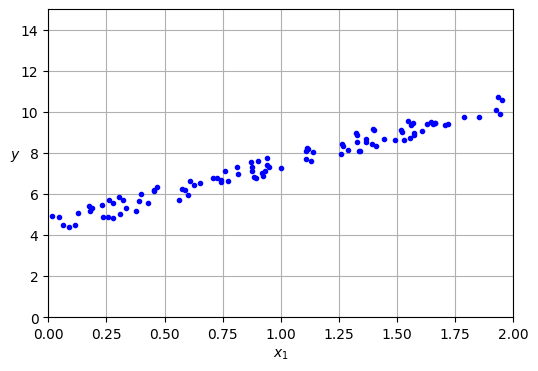

In [32]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

In [33]:
print("X-Data shape: ", X_b.shape, "Transpose: ", X_b.T.shape)
print("y-Data shape: ", y.shape)

X-Data shape:  (100, 2) Transpose:  (2, 100)
y-Data shape:  (100, 1)


In [34]:
from sklearn.preprocessing import add_dummy_feature  # Se usa para aumentar el dataset agreando una dummy feature (generalmente vale 1)

X_b = add_dummy_feature(X)  # Using a dummy variable to simulate theta_0 = 1
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y  # Maximum Likehood estimation solution for the parameters 
print("Analytic Theta: \n", *theta_best)


Analytic Theta: 
 [4.57201738] [2.92706591]


In [35]:
# Usamos y = X * theta_best 
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # add x0 = 1 to each instance
y_predict = X_new_b @ theta_best
print("X_new", *X_new_b)
print("y_pred", *y_predict)

X_new [1. 0.] [1. 2.]
y_pred [4.57201738] [10.42614921]


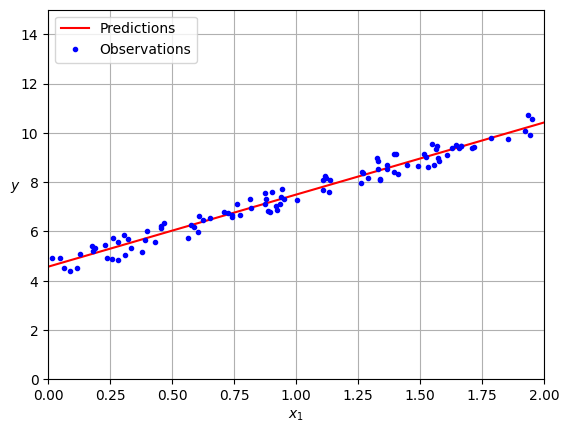

In [36]:
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.", label="Observations")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

In [37]:
# Using the linear regression model from sklearn
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(X, y)
print("Intercept: ", LR.intercept_, "Slope: ", LR.coef_)  # Coincides with the line simulated

Intercept:  [4.57201738] Slope:  [[2.92706591]]


## Implementation

In [38]:
def MSE_gradient(X: np.ndarray, y: np.ndarray, Theta: np.ndarray): 
    """Mean Squared Error"""
    m = len(X)
    return (2 / m) * X.T @ (X @ Theta - y)

### BGD

In [ ]:
class BGD: 
    """Clase base para algoritmos de gradient descent."""
    def __init__(self):
        pass

    def optimice(): 
        pass

### SGD

In [ ]:
class SGD: 
    pass

### Mini-batch GD

In [ ]:
class MiniBatchGD: 
    pass

## Results

## Conclusion